# Acceptance x Efficiency for VLL Singlet and Doublet

Final states I am interested in:
- 4L inclusive
- Exactly 3L
- Exactly 2L and same-sign
- Exactly 2L and opposite-sign
- Exactly 1L and jets (0, 1, 2+)

I am comparing the numbers with Yash.

---
### Object level selections:
##### Muons medium-ID (loose-ID) :
```
- pT > 10, abs(eta) < 2.4
- dxy < 0.05 and dz < 0.1
- pfreliso03 < 0.15 (0.30)
- mediumId (looseId)
```

##### Electrons medium-ID (loose-ID)
```
- pT > 10, abs(eta) < 2.4
- dxy < 0.05/0.10 (barrel/endcap)
- dz < 0.1/0.2 (barrel/endcap)
- pfreliso03 < 0.15 (medium only)
- cutbased > 2 (1)
- away from all medium muons by 0.50
```
##### Taus
```
- pT > 20, abs(eta) < 2.3
- Away from all medium light leptons by 0.5
- deep tau ID

```
##### Jets
```
- pT > 30, abs(eta) < 2.4
- Away from loose leptons by 0.5, taus by 0.5
- jetID > 1 (2) for 2016 (17, 18)
- bTag theshold : 0.4184 on the deepCSV score
```

I am guessing that Yash is using the medium ID muons and electrons as analysis objects and using the light lepton array to clean the Jets. The only difference is that I am aldditionally using the Tau collection to clean the jets. This might cause some minor mis-count of events.


### Trigger:
The event should have at least one muon with pT>26 GeV, or one electron with pT>30 GeV. Right now I am not considering whether this lepton should be a part of the final state object or not (for channels containing more than one leptons).

### Filling up the final states: 
<br>
<div style="text-align:center; font-size:larger; font-weight:bold;">
    4L(incl) > 3L > 2LOS and 2LSS > 1L2J(incl) > 1L1J > 1L0J
</div>
<br>

I used `else if` so that these channels are orthogonal to each other.

---

### Plotting:

In [1]:
import ROOT
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.26/10


In [10]:
!python organize.py --jobname hst_signal_Nov17_straight --date 2023-11-17;

Removing alreading existing file - ../input_files/hst_VLLS_ele_M100.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M125.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M150.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M200.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M250.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M300.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M350.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M400.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M450.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M500.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M750.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_ele_M1000.root ... 
Removing alreading existing file - ../input_files/hst_VLLS_mu_M

#### Creating an output directory to dump the plots

In [3]:
from datetime import datetime

datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')

print('Plot directory ready!')

Plot directory ready!


#### Preparing some global variables for the plotmaker

In [4]:
thin_line = {
    'marker':'o',
    'linestyle':'--',
    'markersize':3,
    'linewidth':1
}
thick_line = {
    'marker':'o',
    'linestyle':'-',
    'markersize':4,
    'linewidth':2
}

masses = [100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 600, 750, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200]
channel_dict = {
    '1L0J':{'color':'yellow',},
    '1L1J':{'color':'gold'},
    '1L2J':{'color':'orange'},
    '2LOS':{'color':'blue'},
    '2LSS':{'color':'cyan'},
    '3L'  :{'color':'green'},
    '4L'  :{'color':'red'}
}

def accp(num, den):
    if den==0 : return 0
    else : return (num/den)*100

### Defining the plotmaker which works for a given model and flavor
I am creating a datafram that stores the acceptance for each final state in different column, and each row represents a mass point. This is handy for plotting. I am also prining out the raw number of events (without lumi-scaling) in each final state, as well as the total number in the files.

**Note : Correction in the VLLD files** :
The VLLD models contain some <span style="color:red;">invalid</span> decay modes which are mentioned below.<br>
<div style="text-align:center;">
    $L\rightarrow W\nu_\tau$<br>
    $N\rightarrow H\nu_\tau, Z\nu_\tau$
</div>
We calculate acceptance by doing <code>nevt_in_channel/nevt_in_file</code>. However, in this case, the denomnator itself is reducing because of the event flag I used to get rid of these invalid decays. However, the effect on the numerator may not be the same. That's why I expect the numbers to be differnt from that of Yash. These is no such modification to the singlet models.

In [5]:
def print_info(model, flav):
    global channel_dict
    global thin_line
    global thick_line
    
    print('-' * 25 + f'\nFor the model {model}_{flav}\n' + '-' * 25)
    print(f'mass\tnAll\tn1L0J\t\tn1L1J\t\tn1L2J\t\tn2LOS\t\tn2LSS\t\tn3L\t\tn4L')

    data_list = []

    for mass in masses:
        
        
        filename = f'../input_files/hst_{model}_{flav}_M{mass}.root'
        file_exists = os.path.exists(filename)
        if file_exists:
            tfile = ROOT.TFile(filename)
            hist = tfile.Get(f'finalstates_incldecay')
            nall = hist.GetBinContent(1)

            print(f'{mass}\t{int(nall)}', end='\t')
            row_dict = {'mass': mass, 'nAll': int(nall)}

            index = 2
            for channel, info in channel_dict.items():
                nevt_ch = hist.GetBinContent(index)
                accp_ch = accp(nevt_ch, nall)
                index = index + 1

                print(f'{int(nevt_ch)} ({accp_ch:.1f}%)', end='\t')
                row_dict[channel] = accp_ch

            data_list.append(row_dict)

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list)
    
    #print('\n\nDataframe containing the acceptance values:')
    #display(df)
    
    #Setting up x and y values from the dataframe.
    x_axis = df['mass'].values
    y_axis = channel_dict = {
        '1L0J':{'color':'yellow',},
        '1L1J':{'color':'gold'},
        '1L2J':{'color':'orange'},
        '2LOS':{'color':'blue'},
        '2LSS':{'color':'cyan'},
        '3L'  :{'color':'green'},
        '4L'  :{'color':'red'}
    }
    for channel, info in y_axis.items():
        y_axis[channel]['acceptance'] =  df[channel].values
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    for channel, info in y_axis.items():
        ax.plot(x_axis, y_axis[channel]['acceptance'], color=y_axis[channel]['color'], label=channel, **thin_line)

    y_multilep = y_axis['3L']['acceptance'] + y_axis['4L']['acceptance']
    y_combined = (y_multilep + y_axis['1L0J']['acceptance'] + y_axis['1L1J']['acceptance'] + y_axis['1L2J']['acceptance'] +
                 y_axis['2LOS']['acceptance'] + y_axis['2LSS']['acceptance'])
    
    ax.plot(x_axis, y_multilep, color='gray',  label='3L+4L', **thick_line)
    ax.plot(x_axis, y_combined, color='black', label=' all combined', **thick_line)
    ax.set_title(f'{model} {flav}', fontsize=14)
    ax.set_xlabel('Mass (GeV)', fontsize=12)
    ax.set_ylabel('acc*eff (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.set_xlim(0, x_axis[-1]*1.2)
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{plotdir}/acceptance_{model}_{flav}_4Lpriority.png', dpi=300)
    plt.show()
    
print('Ready to make plots!')

Ready to make plots!


### VLL Singlet (electron type)

-------------------------
For the model VLLS_ele
-------------------------
mass	nAll	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L
100	599740	1243 (0.2%)	23054 (3.8%)	73091 (12.2%)	16994 (2.8%)	867 (0.1%)	1858 (0.3%)	198 (0.0%)	125	594714	1078 (0.2%)	19509 (3.3%)	113231 (19.0%)	42207 (7.1%)	3339 (0.6%)	8563 (1.4%)	2407 (0.4%)	150	598626	1126 (0.2%)	21401 (3.6%)	171029 (28.6%)	66088 (11.0%)	4736 (0.8%)	11761 (2.0%)	3823 (0.6%)	200	598182	922 (0.2%)	18585 (3.1%)	217613 (36.4%)	90340 (15.1%)	5989 (1.0%)	14756 (2.5%)	5520 (0.9%)	250	496991	649 (0.1%)	13141 (2.6%)	196060 (39.4%)	85381 (17.2%)	5290 (1.1%)	13442 (2.7%)	5382 (1.1%)	300	498516	522 (0.1%)	11196 (2.2%)	204885 (41.1%)	91796 (18.4%)	5610 (1.1%)	14202 (2.8%)	5953 (1.2%)	350	199194	215 (0.1%)	3823 (1.9%)	83735 (42.0%)	38565 (19.4%)	2282 (1.1%)	5900 (3.0%)	2669 (1.3%)	400	199048	172 (0.1%)	3610 (1.8%)	84666 (42.5%)	39395 (19.8%)	2422 (1.2%)	6031 (3.0%)	2744 (1.4%)	450	194893	166 (0.1%)	3302 (1.7%)	83976 (43.1%)	39890 (20.5%)	2369 (1.2%)

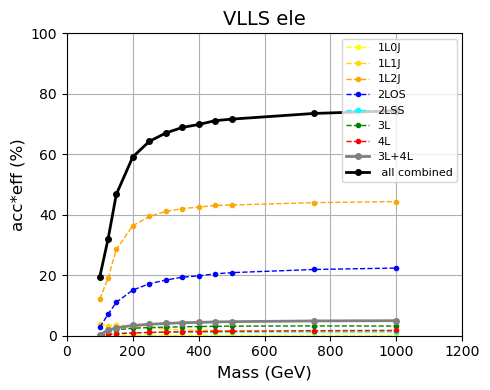

In [6]:
print_info('VLLS', 'ele') 

### VLL Singlet (muon type)

-------------------------
For the model VLLS_mu
-------------------------
mass	nAll	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L
100	594746	1149 (0.2%)	22561 (3.8%)	72867 (12.3%)	17963 (3.0%)	1011 (0.2%)	2592 (0.4%)	392 (0.1%)	125	599690	1362 (0.2%)	23313 (3.9%)	141980 (23.7%)	61492 (10.3%)	3954 (0.7%)	10488 (1.7%)	3862 (0.6%)	150	598660	1284 (0.2%)	24526 (4.1%)	195190 (32.6%)	89802 (15.0%)	4578 (0.8%)	13578 (2.3%)	5772 (1.0%)	200	599555	1049 (0.2%)	20392 (3.4%)	231979 (38.7%)	115776 (19.3%)	5194 (0.9%)	16050 (2.7%)	7347 (1.2%)	250	496540	703 (0.1%)	13620 (2.7%)	202619 (40.8%)	107048 (21.6%)	4363 (0.9%)	14676 (3.0%)	6878 (1.4%)	300	499438	570 (0.1%)	11394 (2.3%)	209824 (42.0%)	113475 (22.7%)	4493 (0.9%)	15199 (3.0%)	7605 (1.5%)	400	198686	189 (0.1%)	3745 (1.9%)	85326 (42.9%)	47992 (24.2%)	1743 (0.9%)	6504 (3.3%)	3429 (1.7%)	450	197673	185 (0.1%)	3348 (1.7%)	86148 (43.6%)	48206 (24.4%)	1670 (0.8%)	6382 (3.2%)	3475 (1.8%)	500	199603	176 (0.1%)	3252 (1.6%)	86779 (43.5%)	49741 (24.9%)	1681 

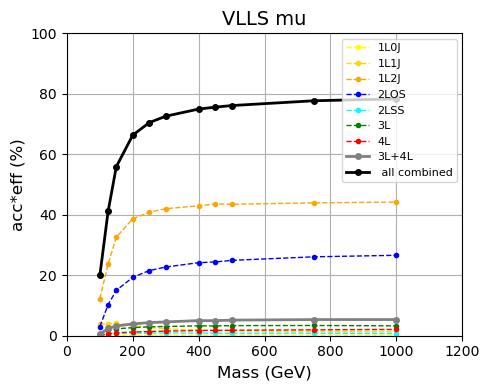

In [7]:
print_info('VLLS', 'mu') 

### VLL Doublet (electron type)

-------------------------
For the model VLLD_ele
-------------------------
mass	nAll	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L
100	110871	200 (0.2%)	2154 (1.9%)	10908 (9.8%)	8976 (8.1%)	3201 (2.9%)	3923 (3.5%)	558 (0.5%)	200	73730	54 (0.1%)	1187 (1.6%)	21767 (29.5%)	29444 (39.9%)	3307 (4.5%)	8340 (11.3%)	1763 (2.4%)	300	24753	8 (0.0%)	194 (0.8%)	6706 (27.1%)	11323 (45.7%)	1076 (4.3%)	3313 (13.4%)	766 (3.1%)	400	24491	8 (0.0%)	116 (0.5%)	6129 (25.0%)	11925 (48.7%)	1095 (4.5%)	3417 (14.0%)	823 (3.4%)	600	24611	9 (0.0%)	122 (0.5%)	6250 (25.4%)	11784 (47.9%)	1121 (4.6%)	3558 (14.5%)	781 (3.2%)	800	23680	3 (0.0%)	56 (0.2%)	5037 (21.3%)	12160 (51.4%)	1094 (4.6%)	3829 (16.2%)	872 (3.7%)	1000	24286	3 (0.0%)	56 (0.2%)	4992 (20.6%)	12680 (52.2%)	1124 (4.6%)	3856 (15.9%)	973 (4.0%)	1200	24336	4 (0.0%)	51 (0.2%)	4971 (20.4%)	12629 (51.9%)	1109 (4.6%)	4033 (16.6%)	1038 (4.3%)	1400	24301	3 (0.0%)	60 (0.2%)	4817 (19.8%)	12768 (52.5%)	1082 (4.5%)	4047 (16.7%)	1012 (4.2%)	1600	24388	4 (0.0%)	55 (0.2%

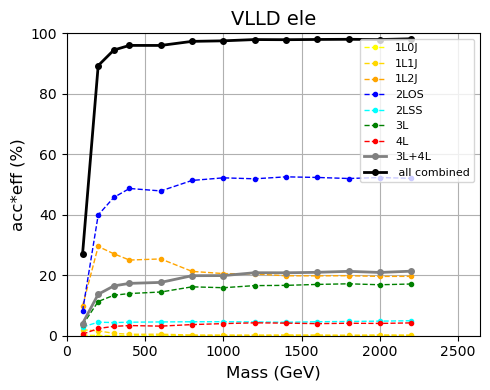

In [8]:
print_info('VLLD', 'ele') 

### VLL Doublet (muon type)

-------------------------
For the model VLLD_mu
-------------------------
mass	nAll	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L
100	111926	176 (0.2%)	2067 (1.8%)	12975 (11.6%)	15219 (13.6%)	3239 (2.9%)	7633 (6.8%)	1070 (1.0%)	200	73908	57 (0.1%)	1129 (1.5%)	14177 (19.2%)	40130 (54.3%)	1869 (2.5%)	10902 (14.8%)	2461 (3.3%)	300	25022	3 (0.0%)	179 (0.7%)	4037 (16.1%)	14665 (58.6%)	565 (2.3%)	4152 (16.6%)	972 (3.9%)	400	24299	3 (0.0%)	91 (0.4%)	3310 (13.6%)	14802 (60.9%)	516 (2.1%)	4310 (17.7%)	1004 (4.1%)	600	24890	2 (0.0%)	50 (0.2%)	3015 (12.1%)	15457 (62.1%)	476 (1.9%)	4664 (18.7%)	1068 (4.3%)	800	24763	4 (0.0%)	40 (0.2%)	2768 (11.2%)	15568 (62.9%)	451 (1.8%)	4608 (18.6%)	1194 (4.8%)	1200	24557	7 (0.0%)	47 (0.2%)	2639 (10.7%)	15459 (63.0%)	420 (1.7%)	4622 (18.8%)	1236 (5.0%)	1400	24798	2 (0.0%)	42 (0.2%)	2673 (10.8%)	15576 (62.8%)	436 (1.8%)	4755 (19.2%)	1193 (4.8%)	1600	24757	1 (0.0%)	40 (0.2%)	2674 (10.8%)	15719 (63.5%)	404 (1.6%)	4611 (18.6%)	1175 (4.7%)	1800	24721	3 (0.0%)	45 (0.2%)

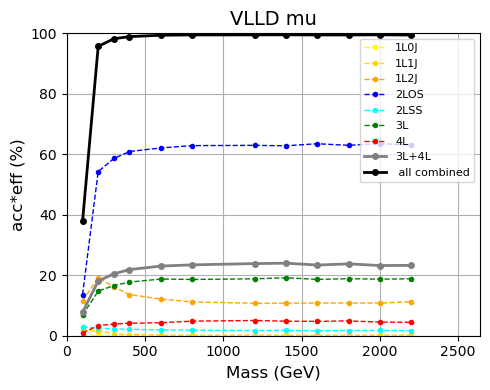

In [9]:
print_info('VLLD', 'mu') 